In [1]:
import gc
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
from typing import Tuple, Union, Optional, List, Dict, Set
from implicit.nearest_neighbours import CosineRecommender, TFIDFRecommender
from numpy.core.multiarray import ndarray
from scipy.sparse import coo_matrix
from ml_metrics import mapk
from tqdm import tqdm
from implicit.als import AlternatingLeastSquares
from sklearn.model_selection import GroupShuffleSplit
import lightgbm as lgb
from sklearn import preprocessing

In [2]:
def get_target(data: pd.DataFrame) -> Dict[int, List[int]]:
    target = dict()
    for row in data.itertuples():
        target[int(row.user_id)] = [int(row.course_id)]
    return target

def train_val_split(dataset: pd.DataFrame) -> Tuple[pd.DataFrame, Dict[int, List[int]]]:
    X = dataset.copy()
    X.reset_index(inplace=True)
    X.sort_values(["user_id", "index"], inplace=True)
    
    X["order"] = 1
    X["order"] = X.groupby("user_id")["order"].cumsum()
    
    max_order = X.groupby("user_id", as_index=False)["order"].max()
    max_order["is_max_order"] = 1
    
    X = X.merge(max_order, "left", on=["user_id", "order"])
    X["is_max_order"] = X["is_max_order"].fillna(0).astype(int)
    
    courses_in_train = X.loc[(X["is_max_order"] == 0) | ((X["is_max_order"] == 1) & (X["order"] == 1)), "course_id"].unique()
    
    mask = (X["is_max_order"] == 1) & (X["order"] != 1) & (X["course_id"].isin(courses_in_train))
    
    X_train = X.loc[~mask, ['user_id','course_id']].copy()
    y_train = get_target(X.loc[mask, ['user_id','course_id']])
    return X_train, y_train

def transform_with_transformation_inplace(column, data, transformation):
    _drop_non_transformed_rows(column, data, transformation)

    non_null_values_mask = ~data[column].isnull().values
    non_null_values = data.loc[non_null_values_mask, column].values.astype(int, copy=False)
    transformed = transformation.values[np.searchsorted(transformation.index.values, non_null_values)]
    del non_null_values
    gc.collect()

    data.loc[non_null_values_mask, column] = transformed
    del non_null_values_mask
    gc.collect()

    data[column] = data[column].astype(int, errors="ignore")


def _drop_non_transformed_rows(column, data, transformation):
    not_transformed = ~fast_isin_for_sorted_test_elements(data[column], transformation.index)
    data.drop(index=data.index[~pd.isnull(data[column]) & not_transformed], inplace=True)


def fast_isin_for_sorted_test_elements(elements: np.ndarray, sorted_test_elements: Union[np.ndarray, pd.Series]) -> np.ndarray:
    if isinstance(sorted_test_elements, pd.Series):
        sorted_test_elements = sorted_test_elements.values

    if sorted_test_elements.size == 0:
        return np.zeros(elements.size, dtype=np.bool)
    if sorted_test_elements.size == 1:
        return elements == sorted_test_elements[0]
    ss_result_left = np.searchsorted(sorted_test_elements, elements, side="left")
    ss_result_left.clip(max=len(sorted_test_elements) - 1, out=ss_result_left)
    result = elements == sorted_test_elements[ss_result_left]
    return result


def get_id_transformations(data: pd.DataFrame, column: str) -> Tuple[pd.Series, pd.Series]:
    """E.g.
        data = pd.DataFrame({'id': [10, None, 30], 'value': [0.1, 0.3, 0.2]})
        column = 'id'

        Returns:
            pd.Series([10, 30, NONE_CONSTANT], index=[0, 1, 2], name='id')
        pd.Series([0, 1, 2], index=[10, 30, NONE_CONSTANT], name='id')
    """
    add_nan = False
    values = data[column].unique()

    if any(pd.isnull(values)):
        values = values[~pd.isnull(values)]
        add_nan = True

    index = np.arange(len(values))
    transformation = pd.Series(values, index=index, name="_" + column)

    if add_nan:
        transformation = transformation.append(pd.Series([NONE_CONSTANT], index=[transformation.index.max() + 1]))

    revert_transformation = pd.Series(transformation.index, index=transformation.values, name="_" + column)
    revert_transformation.sort_index(inplace=True)

    return transformation, revert_transformation


def get_course_user_matrix(
    products: pd.Series, users: pd.Series, matrix_shape: Tuple[int, int], max_value: Optional[int] = None
) -> coo_matrix:
    if len(products) != len(users):
        raise ValueError("Series with products and users must be the same length")

    data = np.ones(products.shape[0])
    matrix = coo_matrix((data, (products, users)), shape=matrix_shape, dtype=np.float32)
    if max_value is not None:
        matrix = matrix.tocsr()
        matrix.data = matrix.data.clip(max=max_value)
        matrix = matrix.tocoo()
    return matrix

def get_recommendations(model: Union[CosineRecommender, TFIDFRecommender], product_user_matrix: coo_matrix, user_ids_to_predict: ndarray, user_id_to_compressed_user_id: pd.Series, compressed_product_id_to_product_id: pd.Series, n: int = 3) -> List[ndarray]:
    recommendations = list()
    user_product_matrix = product_user_matrix.T.tocsr()

    for user_id, transformed_user_id in tqdm(zip(user_ids_to_predict, user_id_to_compressed_user_id[user_ids_to_predict].values)):
        recommendation = model.recommend(userid=transformed_user_id, user_items=user_product_matrix, N=n, recalculate_user=False)
        recommendation = [id for (id, score) in recommendation]
        recommendation = compressed_product_id_to_product_id[np.array(recommendation)].values.tolist()
        recommendations.append(recommendation)
    return recommendations

def add_missing_recommendations(reco: List[int], reco_2: List[int]) -> List[int]:
    for i in reco_2:
        if len(reco) == 3:
            break
        if i in reco:
            continue
        reco += [i]
    return reco

def get_submission(test: pd.DataFrame) -> pd.DataFrame:
    submission = pd.DataFrame({"Id": test["user_id"].values})
    recommendations_as_str = list()

    for row in test.itertuples():
        if row.Predicted is np.nan:
            recommendations_as_str.append("7 1 15")
        else:
            recommendations_as_str.append(" ".join([str(i) for i in row.Predicted]))
    submission["Predicted"] = recommendations_as_str
    return submission

def convert_to_datetime(creation_datetime: str) -> datetime:
    if "\ufeff" in creation_datetime:
        creation_datetime = creation_datetime.replace("\ufeff", "")
    return datetime.strptime(creation_datetime, '%d-%m-%Y %H:%M')

def get_combined_recommendations(reco_1: List[List[int]], reco_2: List[List[int]]) -> List[List[int]]:
    combined_reco  = list()
    for i, j in zip(reco_1, reco_2):
        all_reco = list(set(i) | set(j))
        if len(all_reco) < 3:
            for most_pop in [7, 1, 15]:
                if most_pop in all_reco:
                    continue
                if len(all_reco) == 3:
                    break
                all_reco += [most_pop]
        combined_reco.append(all_reco)
    return combined_reco


def get_ranks_and_scores(model_1: Union[TFIDFRecommender, CosineRecommender], model_2: Union[TFIDFRecommender, CosineRecommender], product_user_matrix: coo_matrix, user_ids_to_predict: ndarray, candidates: List[List[int]], user_id_to_compressed_user_id: pd.Series, course_id_to_compressed_course_id: pd.Series, compressed_course_id_to_course_id: pd.Series) -> pd.DataFrame:
    ranks_and_scores_1 = list()
    ranks_and_scores_2 = list()
    user_product_matrix = product_user_matrix.T.tocsr()

    for user_id, transformed_user_id, cand in tqdm(zip(user_ids_to_predict, user_id_to_compressed_user_id[user_ids_to_predict].values, candidates)):
        selected_items = course_id_to_compressed_course_id[cand].values
        
        rank_score_1 = model_1.rank_items(userid=transformed_user_id, user_items=user_product_matrix, selected_items=selected_items, recalculate_user=False)
        reco_1 = [reco for (reco, score) in rank_score_1]
        reco_1 = compressed_course_id_to_course_id[reco_1].values
        rank_1 = np.arange(len(reco_1))
        score_1 = [score for (reco, score) in rank_score_1]
        
        rank_score_2 = model_2.rank_items(userid=transformed_user_id, user_items=user_product_matrix, selected_items=selected_items, recalculate_user=False)
        reco_2 = [reco for (reco, score) in rank_score_2]
        reco_2 = compressed_course_id_to_course_id[reco_2].values
        rank_2 = np.arange(len(reco_2))
        score_2 = [score for (reco, score) in rank_score_2]
        
        ranks_and_scores_1.append(pd.DataFrame({"user_id": user_id, "course_id": reco_1, "rank_1": rank_1, "score_1": score_1}))
        ranks_and_scores_2.append(pd.DataFrame({"user_id": user_id, "course_id": reco_2, "rank_2": rank_2, "score_2": score_2}))
    
    ranks_and_scores_1 = pd.concat(ranks_and_scores_1, ignore_index=True)
    ranks_and_scores_2 = pd.concat(ranks_and_scores_2, ignore_index=True)
    ranks_and_scores = ranks_and_scores_1.merge(ranks_and_scores_2, "left", ["user_id", "course_id"])
    return ranks_and_scores

def calculate_mean_rank(ranks_and_scores: pd.DataFrame) -> pd.DataFrame:
    mean_rank = ranks_and_scores.copy()
    mean_rank["mean_rank"] = mean_rank[["rank_1", "rank_2"]].mean(axis=1)
    mean_rank = mean_rank.sort_values(["user_id", "mean_rank"]).groupby("user_id", as_index=False).head(3)
    mean_rank = mean_rank.groupby("user_id", as_index=False).agg({"course_id": lambda x: list(x.values)})
    mean_rank.rename(columns={"course_id": "Predicted"}, inplace=True)
    return mean_rank

def get_user_assessments(assessments: pd.DataFrame) -> pd.Series:
    assessments_ = assessments.copy()
    assessments_["course_id"] = assessments_["course_id"].astype(int)
    assessments_ = assessments_.groupby("user_id")["course_id"].apply(lambda x: set(x.values))
    return assessments_

def _add_personal_reco_to_assessments(assessments: List[int], personal_reco: List[int]) -> List[int]:
    reco = assessments[:3]
    
    for i in personal_reco:
        if len(reco) == 3:
            break
        if i in reco:
            continue
        reco += [i]
    return reco

def combine_assessments_and_recommendations(assessments: pd.Series, recs: pd.DataFrame) -> pd.DataFrame:
    assessment_and_reco = [_add_personal_reco_to_assessments(i, j) for i, j  in zip(assessments, recs["Predicted"])]
    assessment_and_reco = pd.DataFrame({"user_id": recs["user_id"].values, "Predicted": assessment_and_reco})
    return assessment_and_reco

def get_first_3_user_assessments(assessments: pd.DataFrame) -> pd.DataFrame:
    assessments_ = assessments.copy()
    assessments_["order"] = 1
    assessments_["order"] = assessments_.groupby("user_id")["order"].cumsum()
    assessments_ = assessments_.loc[assessments_["order"] <= 3].copy()
    assessments_["course_id"] = assessments_["course_id"].astype(int)
    assessments_ = assessments_.groupby("user_id")["course_id"].apply(lambda x: list(x.values))
    return assessments_

def _parse_creation_date(user_course_train: pd.DataFrame) -> pd.DataFrame:
    data = user_course_train[["user_id", "course_id", "created"]].drop_duplicates(subset="user_id").copy()
    data["created"] = data["created"].str.replace(".", "-")
    data["created"] = data["created"].apply(convert_to_datetime)
    data["date"] = data["created"].dt.date
    return data

def get_top_3_most_popular_courses_in_recent_times(data: pd.DataFrame, n_days: int) -> pd.DataFrame:
    X = _parse_creation_date(data)
    
    course_purchases_per_dates = X.copy()
    course_purchases_per_dates["cnt"] = 1
    course_purchases_per_dates = course_purchases_per_dates.pivot_table(values="cnt", index="date", columns="course_id", aggfunc="sum", fill_value=0, dropna=False)
    course_purchases_per_dates = course_purchases_per_dates.reset_index()
    course_purchases_per_dates["date"] = pd.to_datetime(course_purchases_per_dates["date"])
    
    dates_range = pd.DataFrame({"date": pd.date_range('2018-10-10', periods=888, freq='D')})
    dates_range = dates_range.merge(course_purchases_per_dates, "left", "date")
    course_purchases_per_dates = dates_range.fillna(0)
    
    course_purchases_per_dates = course_purchases_per_dates.rolling(n_days, min_periods=0).sum()
    
    course_purchases_per_dates["date"] = pd.DataFrame({"date": pd.date_range('2018-10-10', periods=888, freq='D')})
    course_purchases_per_dates = course_purchases_per_dates.set_index("date")
    course_purchases_per_dates = course_purchases_per_dates.rank(axis=1, method="min")
    
    course_popularity = list()

    for col in course_purchases_per_dates.T.columns:
        top_3 = course_purchases_per_dates.T.nlargest(3, col).index.values.tolist()
        course_popularity.append(top_3)
        
    course_popularity = pd.DataFrame({"date": course_purchases_per_dates.T.columns.values, "Predicted": course_popularity})
    return course_popularity

def get_top_3_for_new_users(data: pd.DataFrame, course_popularity: pd.DataFrame, users_ids: ndarray) -> pd.DataFrame:
    X = _parse_creation_date(data)
    
    X = X.groupby("date").agg({"user_id": "max"})
    X["cum"] = X["user_id"].cummax()
    X.drop(columns="user_id", inplace=True)
    X = X.reset_index()
    
    user_registration_date = pd.DataFrame({"date": np.nan, "cum": users_ids})
    
    user_registration_date = pd.concat((X, user_registration_date), ignore_index=True)
    user_registration_date.sort_values("cum", inplace=True)
    user_registration_date["date"] = user_registration_date["date"].fillna(method='backfill')
    user_registration_date["date"] = pd.to_datetime(user_registration_date["date"])
    
    user_registration_date = user_registration_date.merge(course_popularity, "left", "date")
    user_registration_date.rename(columns={"cum": "user_id"}, inplace=True)
    user_registration_date = user_registration_date.loc[user_registration_date["user_id"].isin(users_ids)].copy()
    user_registration_date.drop(columns="date", inplace=True)
    return user_registration_date

In [3]:
N_RECO = 50

# Загрузка данных

In [4]:
assessment_train = pd.read_csv("assessment_train.csv", index_col=0)
course = pd.read_csv("course.csv", delimiter=";") 
lessons_homework_train = pd.read_csv("lessons_homework_train.csv", index_col=0)
user_course_train = pd.read_csv("user_course_train.csv", index_col=0)
test = pd.read_csv("test_ids.txt", header=None, names=["user_id"])

# EDA

Есть три группы пользователей:
- Пользователи по которым есть данные о покупках курсов (группа 1, 803). Из них по 732 пользователям есть данные по пройденным тестам.
- Пользователи по которым есть данные только о пройденных тестах (группа 2, 356).
- Пользователи о которым нет никакой информации (группа 3, 2751)

In [5]:
assessment_ids = assessment_train["user_id"].unique()
user_course_train_ids = user_course_train["user_id"].unique()
test_ids = test["user_id"].unique()

In [6]:
assessment_ids = np.intersect1d(assessment_ids, test_ids)
ids_group_1 = np.intersect1d(user_course_train_ids, test_ids)
ids_group_1_with_assessment = assessment_ids[np.isin(assessment_ids, ids_group_1)]
ids_group_2 = assessment_ids[~np.isin(assessment_ids, ids_group_1)]
ids_group_3 = test_ids[~np.isin(test_ids, np.union1d(ids_group_1, ids_group_2))]

In [7]:
print(len(ids_group_1) / len(test_ids) * 100)

20.537084398976983


In [8]:
print(len(ids_group_2) / len(test_ids) * 100)

9.104859335038364


In [9]:
print(len(ids_group_3) / len(test_ids) * 100)

70.35805626598466


__О 70% пользователей из теста у нас нет почти никакой информации!__ 

Так как большая часть пользователей в тесте, это пользователи по которым у нас нет данных, то очень многое будет зависеть от того каким образом мы будем делать рекомендации именно для этой категории. 

In [10]:
X = user_course_train[['user_id','course_id']].copy().drop_duplicates()

Посмотрим распределение - какое количество курсов проходили пользователи.

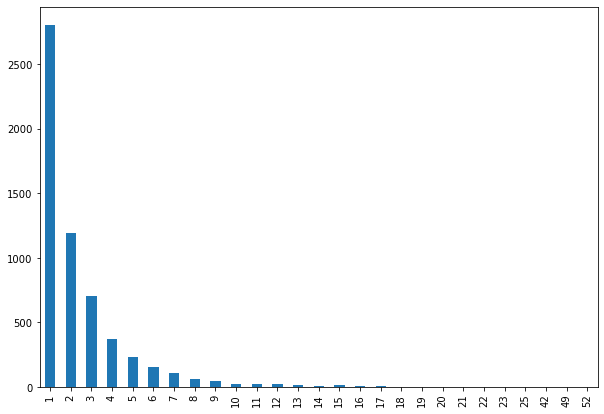

In [11]:
X.groupby("user_id")["course_id"].count().value_counts().sort_index().plot.bar(figsize=(10, 7))
plt.show()

Из обучающих данных видно, что большая часть пользователей прошла только один курс. Однако есть и аномалии, кто то из пользоателей прошел аж 52 курса. 

Посмотрим распределение - какое количество людей прошло/оплатило каждый курс.

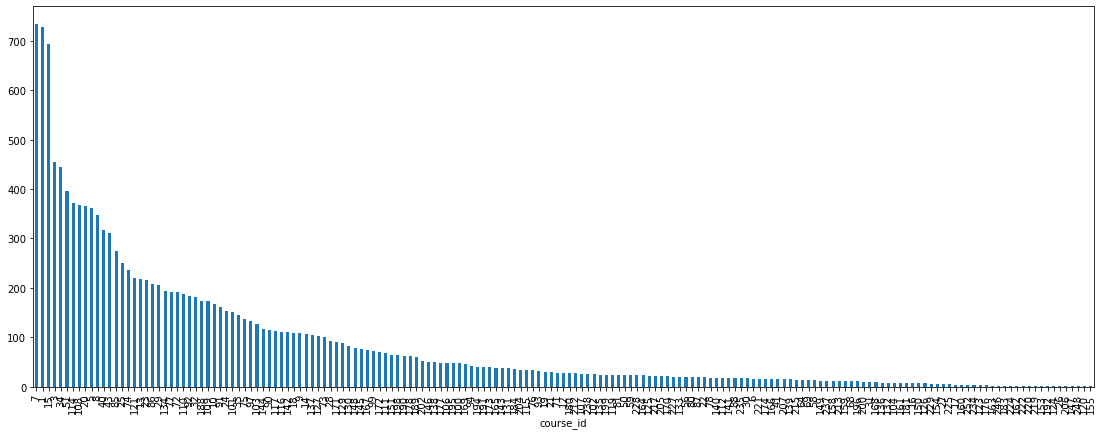

In [12]:
X.groupby("course_id")["user_id"].count().sort_values(ascending=False).plot.bar(figsize=(19, 7))
plt.show()

Есть 3 курса, которые выделяются по популярности на общем фоне, а в остальном картинка вполне обычная, классический "long tail".

In [13]:
course.loc[course["id"].isin([7, 1, 15])]

,id,title,salary,enabled,description,icon,assessment_duration,shortname,assessment_min,short_description,...,ga_goal_request_without_test_send,ya_goal_request_without_test_not_send,ya_goal_request_without_test_send,text_assessment_before_test_with_test_description,text_assessment_before_test_with_test_header,text_assessment_before_test_without_test_description,text_assessment_before_test_without_test_header,dont_show_in_schedule,tilda_html,tilda_page_id
0,1,Java Developer. Professional,160000.0,1.0,<p>Вы получите <strong>практику</strong> решен...,d7/19/d71915b397a94461827988c04e4e9950.png,30.0,Java,8.0,На курсе изучаются особенности языка и платфор...,...,NaN,NaN,NaN,NaN,<p>Для начала тестирования необходимо зарегист...,NaN,"<p>Для того чтобы оставить заявку, нужно зарег...",0,NaN,NaN
6,7,DevOps практики и инструменты,150000.0,1.0,<p><strong>Курс от нашего партнера Express 42<...,a9/98/a998313ce01a41ada55f0fb388d91ceb.png,30.0,DevOps,15.0,DevOps решает задачу взаимодействия инженеров ...,...,NaN,NaN,NaN,NaN,<p>Для начала тестирования необходимо зарегист...,NaN,"<p>Для того чтобы оставить заявку, нужно зарег...",0,NaN,NaN
14,15,Administrator Linux. Professional,120000.0,1.0,<i>Стенды для отработки материалов предоставля...,07/3a/073ac47e083e4b2cb6ef5e76fa591d85.png,30.0,NaN,8.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN


Посмотрим когда по времени впервые встречаются id-шки пользователей.

In [14]:
users_ids_with_dates = user_course_train[["user_id", "course_id", "created"]].drop_duplicates(subset="user_id").copy()
users_ids_with_dates["created"] = users_ids_with_dates["created"].str.replace(".", "-")
users_ids_with_dates["created"] = users_ids_with_dates["created"].apply(convert_to_datetime)
users_ids_with_dates["date"] = users_ids_with_dates["created"].dt.date

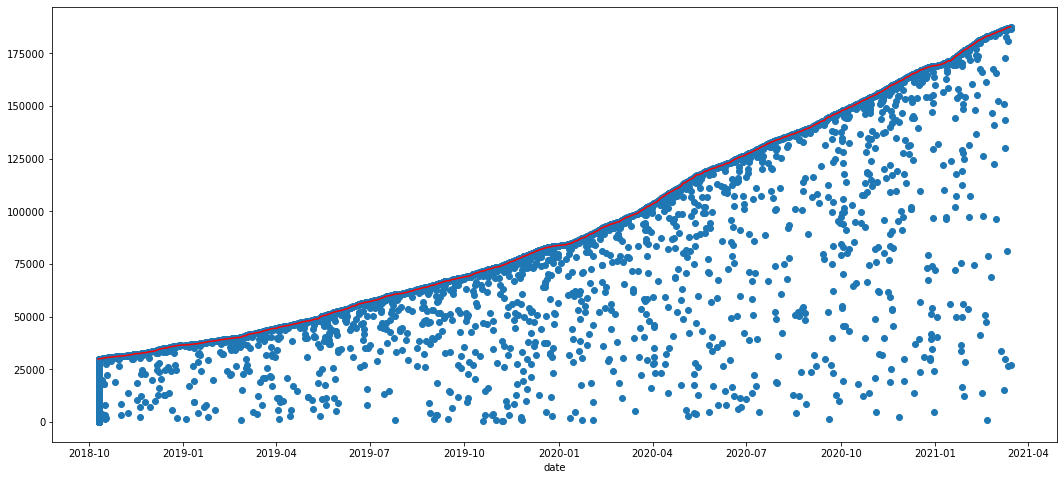

In [15]:
plt.figure(figsize=(18, 8))
plt.scatter(users_ids_with_dates["created"].values, users_ids_with_dates["user_id"].values)
users_ids_with_dates.groupby("date")["user_id"].max().cummax().plot(color="r")
plt.show()

Видно что большая часть id образуют некую линию. Cкорее всего изначально столбца "created" не было, потом его создали и всем имеющимся на тот момент пользователям присвоили дефолтное значение 10/10/2018. Т.к. судя по индексам обучающего набора данных, он получен путем сэмплирования случайным образом, и у нас в распоряжении есть далеко не все данные про действия пользователей, то точки которые лежат не на прямой, возможно, это повторные покупки.

Глядя на эту картинку можно предположить, что мы можем попробовать восстановить дату регистрации пользователя по его id. 

Так же посмотрим как меняется во времени популярность курсов.

In [16]:
users_ids_with_dates["cnt"] = 1
users_ids_with_dates = users_ids_with_dates.pivot_table(values="cnt", index="date", columns="course_id", aggfunc="sum", fill_value=0, dropna=False)
users_ids_with_dates = users_ids_with_dates.reset_index()
users_ids_with_dates["date"] = pd.to_datetime(users_ids_with_dates["date"])

In [17]:
courses_popularity_by_dates = pd.DataFrame({"date": pd.date_range('2018-10-10', periods=888, freq='D')})
courses_popularity_by_dates = courses_popularity_by_dates.merge(users_ids_with_dates, "left", "date")
courses_popularity_by_dates = courses_popularity_by_dates.fillna(0)
courses_popularity_by_dates = courses_popularity_by_dates.rolling(7, min_periods=0).sum()
courses_popularity_by_dates["date"] = pd.DataFrame({"date": pd.date_range('2018-10-10', periods=888, freq='D')})
courses_popularity_by_dates = courses_popularity_by_dates.set_index("date")

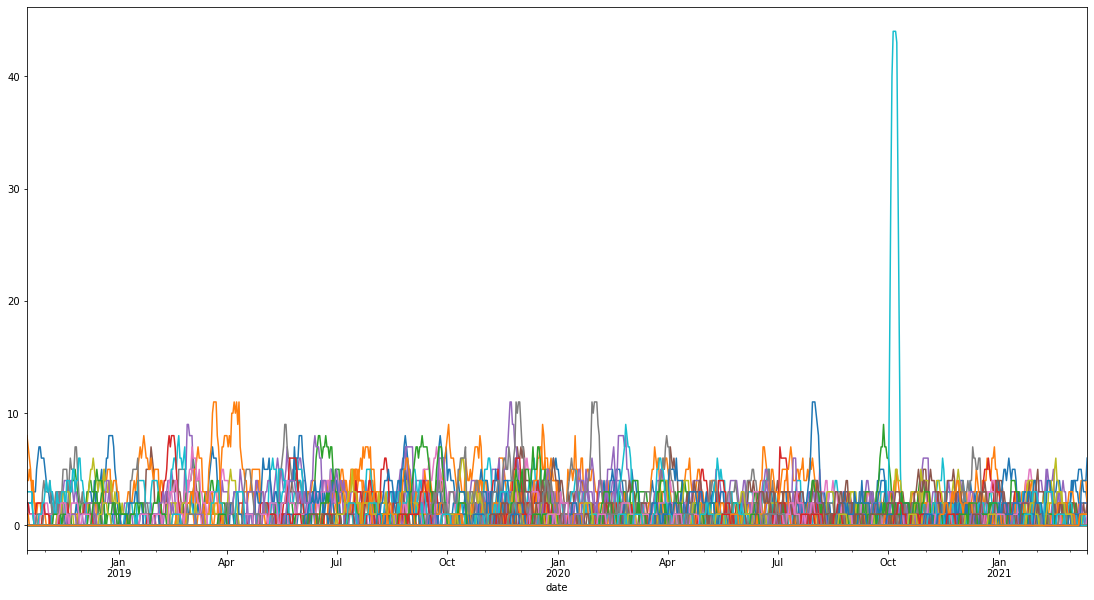

In [18]:
courses_popularity_by_dates["2018-10-17":].plot(figsize=(19, 10), legend=False)
plt.show()

Видно что есть некие всплески популярности отдельных курсов, возможно это связано с маркетинговыми компаниями (рекламой) или с действием акций, скидками.

Возникла гипотеза, что есть значительная часть новых пользователей, которые впервые регистрируются и принимают решение записаться/приобрести курс именно под влиянием различного рода маркетинговых воздействий, действующих акций, скидок и если нам примерно известна дата регистрации пользователя, то мы можем найти топ-3 курсов, которые пользовались наибольшей популярностью на тот момент времени, условно говоря за последнюю неделю (т.е. скользящим окном считаем популярность на определенную дату). Тем самым у нас получаются, можно сказать персонализированные популярные рекомендации, привязанные к дате регистрации.

# 1. Рекомендации для пользователей, по которым есть данные по оплате и пройденным тестам

## 1.1 Обучение и валидация item2item моделей

In [19]:
X_train, y_val = train_val_split(X)

n_users = X_train["user_id"].nunique()
n_courses = X_train["course_id"].nunique()

compressed_user_id_to_user_id, user_id_to_compressed_user_id = get_id_transformations(X_train, "user_id")
compressed_course_id_to_course_id, course_id_to_compressed_course_id = get_id_transformations(X_train, "course_id")

transform_with_transformation_inplace("user_id", X_train, user_id_to_compressed_user_id)
transform_with_transformation_inplace("course_id", X_train, course_id_to_compressed_course_id)

course_user_matrix_shape = (len(compressed_course_id_to_course_id), len(compressed_user_id_to_user_id))
course_user_matrix = get_course_user_matrix(X_train["course_id"], X_train["user_id"], course_user_matrix_shape)

model_tfidf = TFIDFRecommender(K=150)
model_tfidf.fit(course_user_matrix)

model_cos = CosineRecommender(K=150)
model_cos.fit(course_user_matrix)

actual = [course for course in y_val.values()]
user_ids_to_predict = np.array([user_id for user_id in y_val.keys()])
model_tfidf_predictions = get_recommendations(model_tfidf, course_user_matrix, user_ids_to_predict, user_id_to_compressed_user_id, compressed_course_id_to_course_id, N_RECO)
model_cos_predictions = get_recommendations(model_cos, course_user_matrix, user_ids_to_predict, user_id_to_compressed_user_id, compressed_course_id_to_course_id, N_RECO)

154it [00:00, 1525.71it/s]

3017it [00:01, 2662.94it/s]
3017it [00:01, 2777.23it/s]


In [20]:
print(f"TFIDFRecommender map@3: {mapk(actual, model_tfidf_predictions, 3)}") 

TFIDFRecommender map@3: 0.1851729090708209


In [21]:
print(f"CosineRecommender map@3: {mapk(actual, model_cos_predictions, 3)}") 

CosineRecommender map@3: 0.1858358192464921


In [22]:
combined_reco = get_combined_recommendations(model_tfidf_predictions, model_cos_predictions)

In [23]:
assert min([len(i) for i in combined_reco]) >= 3

In [24]:
ranks_and_scores = get_ranks_and_scores(model_tfidf, model_cos,
                                        course_user_matrix,
                                        user_ids_to_predict,
                                        combined_reco,
                                        user_id_to_compressed_user_id,
                                        course_id_to_compressed_course_id,
                                        compressed_course_id_to_course_id)

3017it [00:16, 177.93it/s]


In [25]:
assert np.intersect1d(ranks_and_scores["user_id"].unique(), user_ids_to_predict).shape[0] == 3017

In [26]:
reco_group_1 = calculate_mean_rank(ranks_and_scores)

In [27]:
mapk(actual, [row.Predicted for row in reco_group_1.itertuples()], 3)

0.18456524140978894

## 1.2 Предсказание

In [29]:
transform_with_transformation_inplace("user_id", X, user_id_to_compressed_user_id)
transform_with_transformation_inplace("course_id", X, course_id_to_compressed_course_id)

course_user_matrix = get_course_user_matrix(X["course_id"], X["user_id"], course_user_matrix_shape)

model_tfidf = TFIDFRecommender(K=150)
model_tfidf.fit(course_user_matrix)

model_cos = CosineRecommender(K=150)
model_cos.fit(course_user_matrix)

model_tfidf_predictions = get_recommendations(model_tfidf, course_user_matrix, ids_group_1, user_id_to_compressed_user_id, compressed_course_id_to_course_id, N_RECO)
model_cos_predictions = get_recommendations(model_cos, course_user_matrix, ids_group_1, user_id_to_compressed_user_id, compressed_course_id_to_course_id, N_RECO)

165it [00:00, 1634.31it/s]

803it [00:00, 2447.23it/s]
803it [00:00, 2914.60it/s]


In [30]:
combined_reco = get_combined_recommendations(model_tfidf_predictions, model_cos_predictions)

In [31]:
assert min([len(i) for i in combined_reco]) >= 3

In [32]:
ranks_and_scores = get_ranks_and_scores(model_tfidf,
                                        model_cos,
                                        course_user_matrix,
                                        ids_group_1,
                                        combined_reco,
                                        user_id_to_compressed_user_id,
                                        course_id_to_compressed_course_id,
                                        compressed_course_id_to_course_id)

803it [00:04, 193.65it/s]


In [33]:
assert np.intersect1d(ranks_and_scores["user_id"].unique(), ids_group_1).shape[0] == len(ids_group_1)

In [34]:
reco_group_1 = calculate_mean_rank(ranks_and_scores)

## 1.3  К курсам с пройденными тестами добавляем персональные рекомендации

In [35]:
group_1_assessments = get_user_assessments(assessment_train.loc[assessment_train["user_id"].isin(ids_group_1_with_assessment)])
group_1_courses = user_course_train.loc[user_course_train["user_id"].isin(ids_group_1_with_assessment)].groupby("user_id")["course_id"].apply(lambda x: set(x.values))

In [36]:
user_assessments_without_purchased_courses = group_1_assessments - group_1_courses
reco_group_1_with_purchases_and_assessments = reco_group_1.loc[reco_group_1["user_id"].isin(ids_group_1_with_assessment)].copy()

In [37]:
reco_group_1_with_assessments = combine_assessments_and_recommendations(user_assessments_without_purchased_courses.apply(list), reco_group_1_with_purchases_and_assessments)
reco_group_1_without_assessments = reco_group_1.loc[reco_group_1["user_id"].isin(ids_group_1[~np.isin(ids_group_1, ids_group_1_with_assessment)])].copy()

In [38]:
reco_group_1 = pd.concat((reco_group_1_with_assessments, reco_group_1_without_assessments), ignore_index=True)

In [39]:
assert np.intersect1d(reco_group_1["user_id"].unique(), ids_group_1).shape[0] == len(ids_group_1)

# 2. Рекомендации для пользователей, по которым есть данные только про оценки

In [40]:
X_assessments = assessment_train.loc[assessment_train["user_id"].isin(ids_group_2), ["user_id", "course_id"]].copy()
X_assessments.drop_duplicates(inplace=True)

In [41]:
X_user_courses = user_course_train[['user_id','course_id']].copy().drop_duplicates()
X = pd.concat((X_user_courses, X_assessments), ignore_index=True)
X["course_id"] = X["course_id"].astype(int)

In [42]:
n_users = X["user_id"].nunique()
n_courses = X["course_id"].nunique()

compressed_user_id_to_user_id, user_id_to_compressed_user_id = get_id_transformations(X, "user_id")
compressed_course_id_to_course_id, course_id_to_compressed_course_id = get_id_transformations(X, "course_id")

transform_with_transformation_inplace("user_id", X, user_id_to_compressed_user_id)
transform_with_transformation_inplace("course_id", X, course_id_to_compressed_course_id)

course_user_matrix_shape = (len(compressed_course_id_to_course_id), len(compressed_user_id_to_user_id))
course_user_matrix = get_course_user_matrix(X["course_id"], X["user_id"], course_user_matrix_shape)

model_tfidf = TFIDFRecommender(K=150)
model_tfidf.fit(course_user_matrix)

group_2_reco = get_recommendations(model_tfidf, course_user_matrix, ids_group_2, user_id_to_compressed_user_id, compressed_course_id_to_course_id, 3)
group_2_reco = pd.DataFrame({"user_id": ids_group_2, "Predicted": group_2_reco})

356it [00:00, 2242.76it/s]

In [43]:
group_2_assessments = get_first_3_user_assessments(X_assessments)

In [44]:
reco_group_2 = combine_assessments_and_recommendations(group_2_assessments, group_2_reco)

In [45]:
assert np.intersect1d(reco_group_2["user_id"].unique(), ids_group_2).shape[0] == len(ids_group_2)

# 3. Рекомендации для пользователей, по которым нет данных

In [46]:
course_rolling_popularity = get_top_3_most_popular_courses_in_recent_times(user_course_train, 5)

In [47]:
reco_group_3 = get_top_3_for_new_users(user_course_train, course_rolling_popularity, ids_group_3)

In [48]:
assert np.intersect1d(reco_group_3["user_id"].unique(), ids_group_3).shape[0] == len(ids_group_3)

# 4. Объединяем рекомендации для всех 3-х групп пользователей

In [49]:
all_reco = pd.concat((reco_group_1, reco_group_2, reco_group_3), ignore_index=True)
all_reco = test.merge(all_reco, "left", "user_id")

In [50]:
submission = get_submission(all_reco) 
submission.to_csv("submission_26.csv", index=False)